# Homework 4
### ASTROINFORMATICS
https://github.com/astromundus/astroinfo2018


## Problem

The flux vs. time plot below shows UV flux measurements for an active M dwarf
star. These stars are known for their exponential bursts of energy, well described
by the profile:

$$\rm{flux(time)} = A\,exp(-\alpha \, t)$$ 

for $t>T$ (recall Week-5-Thu lecture).

Find how many bursts were observed for this star during the provided 2 hour 
stretch of data and estimate their amplitudes (A), decay constants ($\alpha$),
and the time of bursts.

**Hints:**
- You can relatively easily solve this problem by generalizing the code from [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)
- There are no more than 2 bursts in this dataset. I.e., you can fit a single-burst model, and then a double-burst model, and then compare which one fits better. Show the posteriors plots (like in [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)) for both models.
- You can use flat priors for A and T and the background (non-bursting) flux level, and Jeffreys' prior, $p(\alpha) \propto \alpha^{-1}$, for $\alpha$
- You can do approximate model comparison based on the BIC 

/home/olena/anaconda3/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


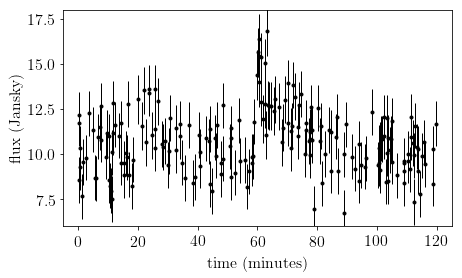

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc

from astroML.plotting.mcmc import plot_mcmc
from astroML.decorators import pickle_results

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=16, usetex=True)

# read data
data = np.loadtxt('data/HW4dataFinal.txt', unpack=True)
t, y_obs, sigma_y = data

# plot data
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('time (minutes)')
ax.set_ylabel(r'flux (Jansky)')

plt.show()

## Single-burst model

 [-----------------100%-----------------] 25000 of 25000 complete in 7.6 sec

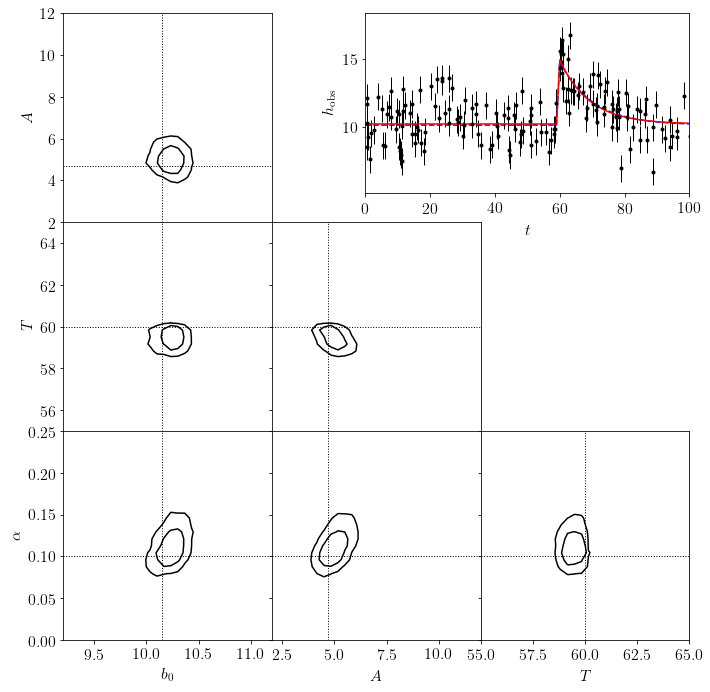

b_0=10.2322,A=5.2677,alpha=0.1107,T=59.0239


In [2]:
def burst1(t, b0, A, alpha, T):
    """Burst model"""
    y = np.empty(t.shape)
    y.fill(b0)
    mask=(t >= T)
    y[mask] += A * np.exp(-alpha * (t[mask] - T))
    return y

b0_true = 10.15
A_true = 4.7
alpha_true = 0.10
T_true = 60
sigma = 1.0


# Generate the burst data -- true burst + some background
y_true = burst1(t, b0_true, A_true, alpha_true, T_true)

# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
log_alpha = pymc.Uniform('log_alpha', -10, 10, value=0)


# uniform prior on log(alpha)
@pymc.deterministic
def alpha(log_alpha=log_alpha):
    return np.exp(log_alpha)


@pymc.deterministic
def y_model(t=t, b0=b0, A=A, alpha=alpha, T=T):
    return burst1(t, b0, A, alpha, T)

y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A, T=T, log_alpha=log_alpha,
             alpha=alpha, y_model=y_model, y=y)


#----------------------------------------------------------------------
# Run the MCMC sampling
# @pickle_results('matchedfilt_burst.pkl')
def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'alpha']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']
limits = [(9.2, 11.2), (2, 12), (55, 65), (0.0, 0.25)]
true = [b0_true, A_true, T_true, alpha_true]

# Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.1, wspace=0.01)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = burst1(t_fit, *fit_vals)
y_true = burst1(t_fit, b0_true, A_true, alpha_true, T_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, sigma, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_true, '--', c='blue')
ax.plot(t_fit, y_fit, '-k', c='red')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')
plt.show() 
print('b_0=%.4f,A=%.4f,alpha=%.4f,T=%.4f' %(fit_vals))

In [3]:
chi1 = np.sum(((y_true-y_fit)/sigma)**2) #find chi-square to estimate BIC for the single-burst model
BIC1=chi1+4*np.log(len(y_true)) #formula for BIC where the number of estimated parameters is 4

## Double-burst model

 [-----------------100%-----------------] 25000 of 25000 complete in 16.9 sec

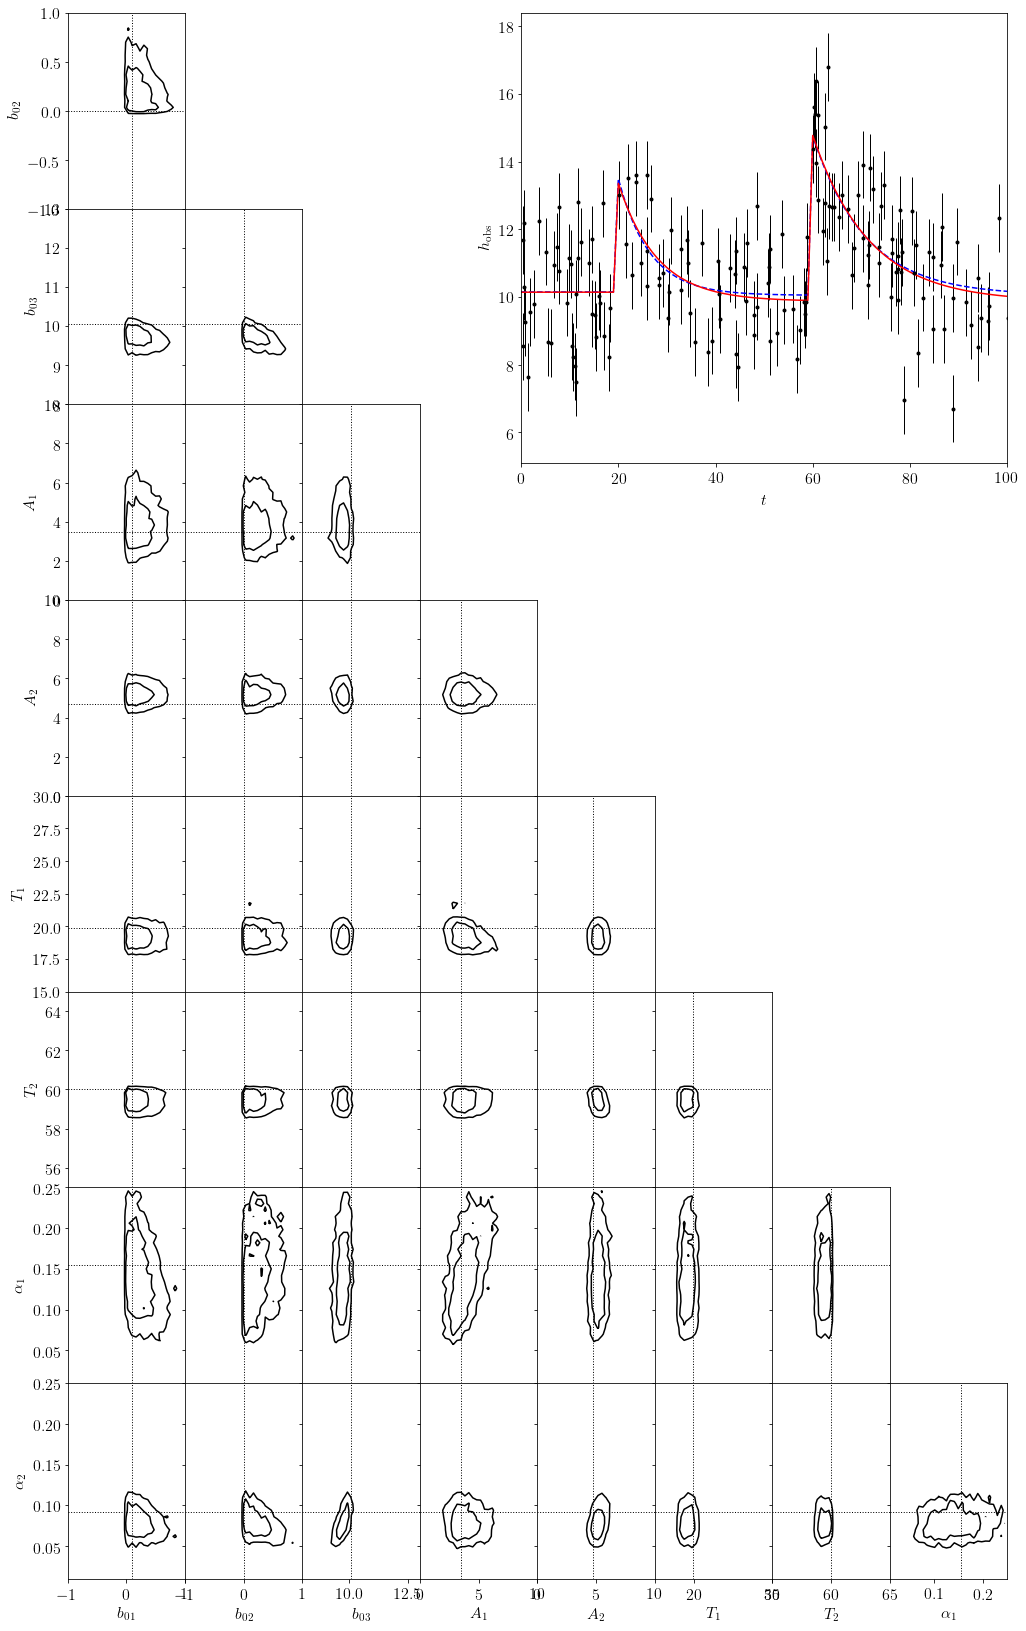

b_01=0.2693,b_02=0.0079,b_03=9.8655,A1=3.6679,A2=4.9908,alpha1=0.1253,alpha2=0.0862,T1=19.5971,T2=59.7600


In [8]:

def burst2(t, b01,b02,b03,A1,A2, alpha1,alpha2,T1,T2):
    """Burst model"""
    y1 = np.empty(t.shape)
    y2 = np.empty(t.shape)
    y3 = np.empty(t.shape)
    y1.fill(b01)
    y2.fill(b02)
    y3.fill(b03) #add b03 to get model with better fit
    
    mask1 =(t >= T1)
    mask2=(t >= T2)
    y1[mask1]=A1 * np.exp(-alpha1 * (t[mask1] - T1))
    y2[mask2]=A2 * np.exp(-alpha2 * (t[mask2] - T2))
    y=y1+y2+y3
    return y

b01_true = 0.1
A1_true = 3.5
alpha1_true =0.155
T1_true = 19.9
sigma = 1.0

b03_true = 10.05
b02_true =0.0
A2_true = 4.7
T2_true = 60
alpha2_true = 0.092

# Generate the burst data -- true burst + some background
y_true = burst2(t, b01_true, b02_true, b03_true, A1_true, A2_true, alpha1_true, alpha2_true, T1_true, T1_true)


# Set up MCMC sampling
b01 = pymc.Uniform('b01', 0, 50, value=50 * np.random.random())
A1 = pymc.Uniform('A1', 0, 50, value=50 * np.random.random())
T1 = pymc.Uniform('T1', 0, 100, value=100 * np.random.random())
log_alpha1 = pymc.Uniform('log_alpha1', -10, 10, value=0)

b02 = pymc.Uniform('b02', 0, 50, value=50 * np.random.random())
b03 = pymc.Uniform('b03', 0, 50, value=50 * np.random.random())
A2 = pymc.Uniform('A2', 0, 50, value=50 * np.random.random())
T2 = pymc.Uniform('T2', 0, 100, value=100 * np.random.random())
log_alpha2 = pymc.Uniform('log_alpha2', -10, 10, value=0)


# uniform prior on log(alpha)
@pymc.deterministic
def alpha1(log_alpha1=log_alpha1):
    return np.exp(log_alpha1)

# uniform prior on log(alpha)
@pymc.deterministic
def alpha2(log_alpha2=log_alpha2):
    return np.exp(log_alpha2)


@pymc.deterministic
def y_model(t=t,b01=b01, b02=b02, b03=b03, A1=A1, A2=A2, alpha1=alpha1, alpha2=alpha2, T1=T1, T2=T2):
    return burst2(t, b01, b02, b03, A1, A2, alpha1, alpha2, T1, T2)

y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

model = dict(b01=b01,b02=b02, b03=b03, A1=A1,A2=A2, T1=T1, T2=T2, log_alpha1=log_alpha1, log_alpha2=log_alpha2, alpha1=alpha1, alpha2=alpha2, y_model=y_model, y=y)

# @pickle_results('matchedfilt_burst.pkl')
def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b01','b02', 'b03','A1','A2', 'T1','T2', 'alpha1','alpha2']]
    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b01.value,M.b02.value, M.b03.value,M.A1.value,M.A2.value, M.alpha1.value,M.alpha2.value, M.T1.value,M.T2.value)

    return traces, fit_vals


traces, fit_vals = compute_MCMC_results()

labels = ['$b_{01}$','$b_{02}$','$b_{03}$', '$A_1$', '$A_2$','$T_1$','$T_2$', r'$\alpha_1$',r'$\alpha_2$']
limits = [(-1, 1),(-1, 1),(8, 13), (0, 10),(0, 10), (15, 30),(55, 65), (0.01, 0.25),(0.01, 0.25)]
true = [b01_true,b02_true,b03_true, A1_true,A2_true, T1_true,T2_true, alpha1_true,alpha2_true]


# Plot the results
fig = plt.figure(figsize=(15, 25))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = burst2(t_fit, *fit_vals)
y_true = burst2(t_fit, b01_true,b02_true,b03_true, A1_true,A2_true, alpha1_true,alpha2_true, T1_true,T2_true)
ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, sigma, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_true, '--', c='blue')
ax.plot(t_fit, y_fit, '-k', c='red')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')
plt.show()
print('b_01=%.4f,b_02=%.4f,b_03=%.4f,A1=%.4f,A2=%.4f,alpha1=%.4f,alpha2=%.4f,T1=%.4f,T2=%.4f' %(fit_vals))

In [9]:
chi2 = np.sum(((y_true-y_fit)/sigma)**2) #find chi-square to estimate BIC for the single-burst model
BIC2=chi2+9*np.log(len(y_true)) #formula for BIC where the number of estimated parameters is 9 for the double-burst

print(r'BIC_single=%.3f, BIC_double=%.3f'%(BIC1,BIC2))

BIC_single=18.979, BIC_double=42.225


Therefore, looking at BIC values we can assume that single-burst model is better than double-burst model, because the BIC value for the single-burst model is lower than BIC value for the double-burst model. However, it should be noted that in order to get the double-burst model I added additional parameter and the set true values are not actually proper true values. It can be noted that it is possible to improve both single- and double-burst models to achieve better fit results (lower BIC values) by determining "true" parameters more carefully.

In addition, it should be noted that here I have a problem that results are not reproduceable: running the code two times I am getting different outputs with the different estimated parameters and different BIC values.